# MACHINE LEARNING REUTERS DATASET ANALYSIS



# INTRODUCTION

## PROBLEM DEFINITION

We use the Universal Workflow blueprint to solve our machine learning problem.
We use the blueprint illustrated in Deep Learning With Phyton by Francois Chollet.
We will apply the following steps to make sure we are addressing the problem correctly.

We are going first to define the problem we are facing.

### WHAT INPUT?

We are going to use the Reuters Dataset which is a benchmark dataset for document classification.

It consists of newswires and their topics which were published by Reutuers in 1986.

The dataset is packaged inside Keras.


### WHAT OUTPUT?

There are 46 different topics some are more common than others.

We want to build a network to classify each newswire into 46 topics.

The problem is one of multi-class classification therefore.

We can also say that is a single-label multiclass classification since each newswire can only belong to a single topic.

If each newswire could belong to multiple topics we would have a multi-label multiclass classification.

In [109]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.datasets import reuters
# we split the dataset in train and test sets and restrict the data to the 10000 most frequent words
(train_data,train_labels),(test_data,test_labels)=reuters.load_data(num_words=10000)

In [110]:
# we print the size of each set
print("Train data length: ",len(train_data))
print("Test data length: ",len(test_data))

Train data length:  8982
Test data length:  2246


In [111]:
# we can see the full list of indices and word associated
tensorflow.keras.datasets.reuters.get_word_index(path="reuters_word_index.json")

{'mdbl': 10996,
 'fawc': 16260,
 'degussa': 12089,
 'woods': 8803,
 'hanging': 13796,
 'localized': 20672,
 'sation': 20673,
 'chanthaburi': 20675,
 'refunding': 10997,
 'hermann': 8804,
 'passsengers': 20676,
 'stipulate': 20677,
 'heublein': 8352,
 'screaming': 20713,
 'tcby': 16261,
 'four': 185,
 'grains': 1642,
 'broiler': 20680,
 'wooden': 12090,
 'wednesday': 1220,
 'highveld': 13797,
 'duffour': 7593,
 '0053': 20681,
 'elections': 3914,
 '270': 2563,
 '271': 3551,
 '272': 5113,
 '273': 3552,
 '274': 3400,
 'rudman': 7975,
 '276': 3401,
 '277': 3478,
 '278': 3632,
 '279': 4309,
 'dormancy': 9381,
 'errors': 7247,
 'deferred': 3086,
 'sptnd': 20683,
 'cooking': 8805,
 'stratabit': 20684,
 'designing': 16262,
 'metalurgicos': 20685,
 'databank': 13798,
 '300er': 20686,
 'shocks': 20687,
 'nawg': 7972,
 'tnta': 20688,
 'perforations': 20689,
 'affiliates': 2891,
 '27p': 20690,
 'ching': 16263,
 'china': 595,
 'wagyu': 16264,
 'affiliated': 3189,
 'chino': 16265,
 'chinh': 16266,
 '

In [112]:
# we can reverse a newswire back to words
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in
train_data[0]])
#label associated with an example is an integer between 0 and 45 (topic index)
print(train_labels[10])
#the decoded newswire
print(decoded_newswire)


3
? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


# METHODOLOGY



## PREPARE DATA

We start with data preprocessing and we also encode the labels as one-hot categorically encoded. One-hot encoding is a widely used format for categorical data.

Some considerations:
- Format as tensors usually scaled to small values range [0,1] or ][-1,1]
- If data is heterogeneous (different ranges) it should be normalized
- Do some feature engineering for small data problem


In [113]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

# vectorize training data
y_train = np.asarray(train_labels).astype('float32')
# vectorize testing data
y_test = np.asarray(train_labels).astype('float32')

In [114]:
# vectorize labels - one-hot encoding embeds each label as an all-zero vector with 1 in the place of the label index
from tensorflow.keras.utils import to_categorical
#vectorize training labels
one_hot_train_labels = to_categorical(train_labels)
#vectorize test labels
one_hot_test_labels = to_categorical(test_labels)


## MODEL

We are trying and classify shorts snippets of text. What we want to achieve is statistical power.

3 choices to build our working model:

- Last Layer Activation (Constraints on the network output)
- Loss Function (match the type of problem we are solving (Cross-Entropy, MSE, ...)
- Optimization Configuration (default is RMSPROP)

    


In [115]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape = (10000,)))
model.add(layers.Dense(64, activation = 'relu'))
#last layer use a softmax activation to output a probability distribution over the 46 different classes
model.add(layers.Dense(46, activation = 'softmax'))



The best loss function is categorical_crossentropy since it measures the distance between 2 probability distributions (the output one and the true distributions of the labels).

We want to minimize this distance to get an output as close as possible to true labels.

We want also to understand which metrics to use.

Being a balanced classification we will use accuracy (ROC AUC could be another option)

If it was an inbalanced classification we could use precision and recall.

Other metrics commonly used are mean,average,precision.


In [116]:
# weight and bias tensors
def print_layer_tensor_shape(layer):
    weight_params = model.layers[layer].get_weights()[0]
    bias_params = model.layers[layer].get_weights()[1]
    print(layer, '\t', weight_params.shape, '\t', bias_params.shape)
    
print_layer_tensor_shape(layer = 0)
print_layer_tensor_shape(layer = 1)
print_layer_tensor_shape(layer = 2)

0 	 (10000, 64) 	 (64,)
1 	 (64, 64) 	 (64,)
2 	 (64, 46) 	 (46,)


In [117]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

## EVALUATION PROTOCOL

Considerations:

Maintain a hold-out validation set

Doing K-fold cross validation

Doing iterated K-fold validation

    


We now want to validate our approach and to do this we will create a validation set.

In [118]:
# we slice 1000 sample in the training data to be reserved as validation set
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [119]:
# we train the model
history = model.fit(partial_x_train,partial_y_train,epochs=20,batch_size=512,validation_data=(x_val,y_val))

model.summary()

Epoch 1/20
16/16 [==============================] - 1s 39ms/step - loss: 2.5371 - accuracy: 0.5436 - val_loss: 1.6939 - val_accuracy: 0.6430
Epoch 2/20
16/16 [==============================] - 0s 26ms/step - loss: 1.4053 - accuracy: 0.7082 - val_loss: 1.3064 - val_accuracy: 0.7160
Epoch 3/20
16/16 [==============================] - 0s 31ms/step - loss: 1.0546 - accuracy: 0.7780 - val_loss: 1.1516 - val_accuracy: 0.7500
Epoch 4/20
16/16 [==============================] - 0s 26ms/step - loss: 0.8352 - accuracy: 0.8252 - val_loss: 1.0490 - val_accuracy: 0.7850
Epoch 5/20
16/16 [==============================] - 0s 26ms/step - loss: 0.6657 - accuracy: 0.8616 - val_loss: 0.9671 - val_accuracy: 0.7990
Epoch 6/20
16/16 [==============================] - 0s 26ms/step - loss: 0.5355 - accuracy: 0.8909 - val_loss: 0.9191 - val_accuracy: 0.8090
Epoch 7/20
16/16 [==============================] - 0s 27ms/step - loss: 0.4350 - accuracy: 0.9100 - val_loss: 0.8904 - val_accuracy: 0.8140
Epoch 8/20
16

In [120]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

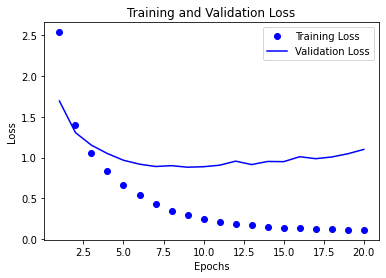

In [121]:
#we plot the training and validation loss
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss) + 1)

plt.plot(epochs,loss,'bo',label = 'Training Loss')
plt.plot(epochs,val_loss,'b',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


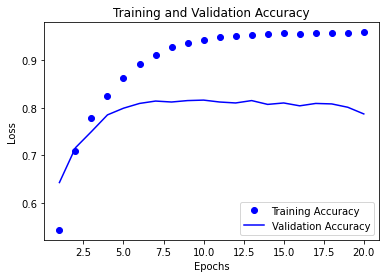

In [122]:
# we plot the training and validation accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs,accuracy,'bo',label='Training Accuracy')
plt.plot(epochs,val_accuracy,'b',label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [123]:
print(np.argmin(val_loss), 'epochs')

8 epochs


# RESULTS

We want to develop a model that neither underfits or overfits.
The challenge is between optimization and generalization. 
Optimization refers to the process of adjusting a model to get the best performance possible on the training data.
Generalization refers to how well the trained model would perform on data it has never seen before. 

The processing of fighting overfitting is called regularization.

To develop a model that neither underfits or overfits we can:
- add layers
- make the layers bigger
- train for more epochs


For regularization and tuning we can:
- add dropout
- try different architectures: add or remove layers
- add L1 and/or L2 regularization
- try different hyperparameters to find optimal configuration
- iterate on feature engineering, add or remove features
- reduce the network size

There is not single recipe to determine the the right number of layers or their size, evaluation of different architectures is important in order to find the right balance for your data. You can star small and increase gradually until you get diminishing returns.

## REDUCE NETWORK SIZE


We can notice from the plot that our network begin to overfit after 8 epochs.

We can test creating a new network for 8 epochs and evaluate it again on the test set.

In [124]:
model = models.Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape = (10000,)))
model.add(layers.Dense(64, activation = 'relu'))
#last layer use a softmax activation to output a probability distribution over the 46 different classes
model.add(layers.Dense(46, activation = 'softmax'))

model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.fit(partial_x_train,partial_y_train,epochs=8,batch_size=512,validation_data=(x_val,y_val))

results = model.evaluate(x_test, one_hot_test_labels)

print(results)

model.summary()


Epoch 1/8
16/16 [==============================] - 1s 33ms/step - loss: 2.7111 - accuracy: 0.4707 - val_loss: 1.8048 - val_accuracy: 0.6410
Epoch 2/8
16/16 [==============================] - 0s 28ms/step - loss: 1.4423 - accuracy: 0.7073 - val_loss: 1.3153 - val_accuracy: 0.7200
Epoch 3/8
16/16 [==============================] - 0s 26ms/step - loss: 1.0445 - accuracy: 0.7771 - val_loss: 1.1247 - val_accuracy: 0.7650
Epoch 4/8
16/16 [==============================] - 0s 26ms/step - loss: 0.8188 - accuracy: 0.8290 - val_loss: 1.0225 - val_accuracy: 0.7910
Epoch 5/8
16/16 [==============================] - 0s 27ms/step - loss: 0.6488 - accuracy: 0.8659 - val_loss: 0.9501 - val_accuracy: 0.8050
Epoch 6/8
16/16 [==============================] - 0s 28ms/step - loss: 0.5182 - accuracy: 0.8924 - val_loss: 0.9299 - val_accuracy: 0.8010
Epoch 7/8
16/16 [==============================] - 0s 26ms/step - loss: 0.4188 - accuracy: 0.9132 - val_loss: 0.9550 - val_accuracy: 0.7950
Epoch 8/8
71/71 [===

We get an accuracy of approximately 79% which is quite good.

## GENERATE PREDICTIONS ON NEW DATA

We can generate topic predictions on the test data

In [125]:
# outline the predictions success
predictions = model.predict(x_test)
print('wire', '\t', 'prod', '\t', 'label')
for i in range(46):
    print(i, '\t', np.argmax(predictions[i]), '\t', test_labels[i])

wire 	 prod 	 label
0 	 3 	 3
1 	 10 	 10
2 	 1 	 1
3 	 4 	 4
4 	 13 	 4
5 	 3 	 3
6 	 3 	 3
7 	 3 	 3
8 	 3 	 3
9 	 3 	 3
10 	 1 	 5
11 	 4 	 4
12 	 1 	 1
13 	 3 	 3
14 	 1 	 1
15 	 11 	 11
16 	 4 	 23
17 	 3 	 3
18 	 19 	 19
19 	 3 	 3
20 	 8 	 8
21 	 3 	 3
22 	 3 	 3
23 	 4 	 3
24 	 9 	 9
25 	 3 	 3
26 	 4 	 4
27 	 6 	 6
28 	 10 	 10
29 	 3 	 3
30 	 3 	 3
31 	 10 	 10
32 	 4 	 20
33 	 3 	 1
34 	 19 	 19
35 	 4 	 4
36 	 19 	 40
37 	 1 	 1
38 	 4 	 4
39 	 3 	 3
40 	 3 	 15
41 	 21 	 21
42 	 3 	 3
43 	 34 	 34
44 	 4 	 4
45 	 4 	 4


In [126]:
predictions = model.predict(x_test)
predictions[0].shape

(46,)

each entry is a vector of lenght 46

In [127]:
np.sum(predictions[0])

1.0

the coefficients sum is 1

In [128]:
np.argmax(predictions[0])

3

this is the class with the largest entry and the class with highest probability

## LARGE INTERMEDIATE LAYERS

Since the outputs have 46 dimensions we should avoid intermediate layers with values much smaller than 46.

If we introduce a small intermediate layer we risk creating an information bottleneck.

In [129]:
model = models.Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape = (10000,)))
# we introduce a small intermediate layer
model.add(layers.Dense(4, activation = 'relu'))
model.add(layers.Dense(46, activation = 'softmax'))

model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.fit(partial_x_train,partial_y_train,epochs=20,batch_size=128,validation_data=(x_val,y_val))

results = model.evaluate(x_test, one_hot_test_labels)

print(results)

model.summary()

Epoch 1/20
63/63 [==============================] - 1s 12ms/step - loss: 3.3697 - accuracy: 0.2175 - val_loss: 2.9096 - val_accuracy: 0.2270
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 2.4485 - accuracy: 0.4035 - val_loss: 2.0027 - val_accuracy: 0.5800
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 1.6926 - accuracy: 0.5960 - val_loss: 1.6476 - val_accuracy: 0.5900
Epoch 4/20
63/63 [==============================] - 1s 11ms/step - loss: 1.4613 - accuracy: 0.5980 - val_loss: 1.5544 - val_accuracy: 0.5910
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 1.3110 - accuracy: 0.6393 - val_loss: 1.4973 - val_accuracy: 0.6360
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 1.1916 - accuracy: 0.6893 - val_loss: 1.4574 - val_accuracy: 0.6480
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 1.0949 - accuracy: 0.7125 - val_loss: 1.4613 - val_accuracy: 0.6590
Epoch 8/20
63

The accuracy drops to approximately 70% since we are trying and compress a lot of information in a small bucket of 4.

We can also experiment with larger and smaller layers and different combinations to see how our accuracy change.

In [130]:
model = models.Sequential()
model.add(layers.Dense(128, activation = 'relu', input_shape = (10000,)))
model.add(layers.Dense(128, activation = 'relu'))
#last layer use a softmax activation to output a probability distribution over the 46 different classes
model.add(layers.Dense(46, activation = 'softmax'))

model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.fit(partial_x_train,partial_y_train,epochs=20,batch_size=512,validation_data=(x_val,y_val))

results = model.evaluate(x_test, one_hot_test_labels)

print(results)

model.summary()

Epoch 1/20
16/16 [==============================] - 1s 46ms/step - loss: 2.2808 - accuracy: 0.5666 - val_loss: 1.4072 - val_accuracy: 0.6750
Epoch 2/20
16/16 [==============================] - 1s 36ms/step - loss: 1.1290 - accuracy: 0.7582 - val_loss: 1.1175 - val_accuracy: 0.7530
Epoch 3/20
16/16 [==============================] - 1s 38ms/step - loss: 0.7943 - accuracy: 0.8327 - val_loss: 0.9810 - val_accuracy: 0.7890
Epoch 4/20
16/16 [==============================] - 1s 38ms/step - loss: 0.5607 - accuracy: 0.8825 - val_loss: 0.9092 - val_accuracy: 0.8050
Epoch 5/20
16/16 [==============================] - 1s 38ms/step - loss: 0.4136 - accuracy: 0.9162 - val_loss: 0.9006 - val_accuracy: 0.8010
Epoch 6/20
16/16 [==============================] - 1s 38ms/step - loss: 0.3186 - accuracy: 0.9302 - val_loss: 0.8615 - val_accuracy: 0.8250
Epoch 7/20
16/16 [==============================] - 1s 38ms/step - loss: 0.2548 - accuracy: 0.9449 - val_loss: 0.9130 - val_accuracy: 0.8130
Epoch 8/20
16

In [131]:
model = models.Sequential()
model.add(layers.Dense(32, activation = 'relu', input_shape = (10000,)))
model.add(layers.Dense(32, activation = 'relu'))
#last layer use a softmax activation to output a probability distribution over the 46 different classes
model.add(layers.Dense(46, activation = 'softmax'))

model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.fit(partial_x_train,partial_y_train,epochs=20,batch_size=512,validation_data=(x_val,y_val))

results = model.evaluate(x_test, one_hot_test_labels)

print(results)

model.summary()

Epoch 1/20
16/16 [==============================] - 1s 26ms/step - loss: 2.9048 - accuracy: 0.4352 - val_loss: 2.1941 - val_accuracy: 0.5590
Epoch 2/20
16/16 [==============================] - 0s 21ms/step - loss: 1.8573 - accuracy: 0.6155 - val_loss: 1.6433 - val_accuracy: 0.6550
Epoch 3/20
16/16 [==============================] - 0s 18ms/step - loss: 1.4096 - accuracy: 0.7090 - val_loss: 1.3904 - val_accuracy: 0.7040
Epoch 4/20
16/16 [==============================] - 0s 22ms/step - loss: 1.1547 - accuracy: 0.7509 - val_loss: 1.2608 - val_accuracy: 0.7180
Epoch 5/20
16/16 [==============================] - 0s 22ms/step - loss: 0.9786 - accuracy: 0.7875 - val_loss: 1.1507 - val_accuracy: 0.7530
Epoch 6/20
16/16 [==============================] - 0s 19ms/step - loss: 0.8382 - accuracy: 0.8196 - val_loss: 1.0888 - val_accuracy: 0.7730
Epoch 7/20
16/16 [==============================] - 0s 19ms/step - loss: 0.7206 - accuracy: 0.8423 - val_loss: 1.0298 - val_accuracy: 0.7920
Epoch 8/20
16

# CONCLUSIONS

We want to scale our model and develop one that neither underfit or overfit.
We can reach this objective in many ways by adding layers or increasing the size of layers or train for more epochs.

If we are classifying data points among N classes we want to use a dense final layer of size N (46 in our case).
We used in our final layer a softmax activation in order to output a probability distribution over the 46 classes.

Categorical Crossentropy is the standard for such problems since it minimize the distance between the probability distributions (the output one and the true distributions of the labels).


